# Machine Learning Foundation

## Course 6, Part g: Time Series Deep Learning DEMO

# Introduction

In previous lessons, we've gone from learning the basic components of time series to employing advanced signal transformation techniques. As the culmination of these lessons, we'll now turn toward deep learning as a method for time series forecasting. We'll see how **recurrent neural networks** can automatically learn how to model series components like seasonality and autocorrelation without special preprocessing. In the process, we'll gain exposure to the python library **Keras**, which provides an excellent interface for constructing neural networks. 

# Learning Outcomes
You should walk away from this Python tutorial with:
1. A practical understanding of how to build and train a simple RNN or LSTM for time series forecasting, using keras.
2. Introductory experience in tuning RNN/LSTM parameters.

# Imports

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
os.chdir('data')
from colorsetup import colors, palette
plt.style.use('fivethirtyeight')
sns.set_palette(palette)
import pandas as pd
from datetime import datetime

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Section 1: Simple RNN

In this section, we will build a recurrent neural network and train it to forecast a single time series. We'll use a dataset provided by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) that measures hourly air quality in Chinese cities/city districts<sup>1</sup>.

1. Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10220â€“10236

#### Setting Up The Data

We'll start by working with Beijing data, and filter the dataset down to records from 2015. 

In [94]:
df_Beijing = pd.read_csv('./FiveCitiesPM/Beijing.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [95]:
df_Beijing.tail(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
52574,52575,2015,12,31,14,4,63.0,NaN,50.0,48.0,-10.0,35.0,1031.0,4.0,SE,1.79,0.0,0.0
52575,52576,2015,12,31,15,4,71.0,61.0,64.0,58.0,-11.0,32.0,1031.0,4.0,SE,3.58,0.0,0.0
52576,52577,2015,12,31,16,4,86.0,75.0,68.0,69.0,-10.0,37.0,1031.0,3.0,SE,4.47,0.0,0.0
52577,52578,2015,12,31,17,4,90.0,102.0,89.0,91.0,-10.0,43.0,1030.0,1.0,SE,5.36,0.0,0.0
52578,52579,2015,12,31,18,4,119.0,117.0,112.0,114.0,-10.0,58.0,1030.0,-3.0,SE,6.25,0.0,0.0
52579,52580,2015,12,31,19,4,140.0,157.0,122.0,133.0,-8.0,68.0,1031.0,-3.0,SE,7.14,0.0,0.0
52580,52581,2015,12,31,20,4,157.0,199.0,149.0,169.0,-8.0,63.0,1030.0,-2.0,SE,8.03,0.0,0.0
52581,52582,2015,12,31,21,4,171.0,231.0,196.0,203.0,-10.0,73.0,1030.0,-6.0,NE,0.89,0.0,0.0
52582,52583,2015,12,31,22,4,204.0,242.0,221.0,212.0,-10.0,73.0,1030.0,-6.0,NE,1.78,0.0,0.0
52583,52584,2015,12,31,23,4,NaN,NaN,NaN,235.0,-9.0,79.0,1029.0,-6.0,NE,2.67,0.0,0.0


We are interested in attempting to forecast the 'PM' series, which are measurements of air pollution for several different districts.  Note that there are occasional missing values in these series, which we can fill with simple linear interpolation. To start, we'll focus on the "PM_Dongsi" series and interpolate the missing values. 

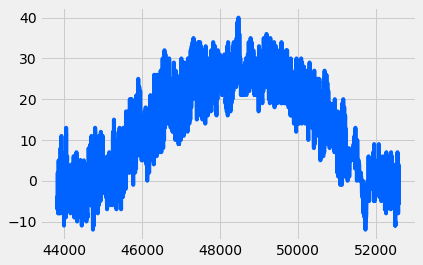

In [96]:
plt.plot(df_Beijing['TEMP'])

In [97]:
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['TEMP'] = df_Beijing['TEMP'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

In [98]:
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,4.0,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [99]:
df_Beijing2 = df_Beijing.copy()

In [100]:
df_Beijing2

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,140.0,157.0,122.0,133.0,-8.0,68.0,1031.0,-3.0,SE,7.14,0.0,0.0
52580,52581,2015,12,31,20,4,157.0,199.0,149.0,169.0,-8.0,63.0,1030.0,-2.0,SE,8.03,0.0,0.0
52581,52582,2015,12,31,21,4,171.0,231.0,196.0,203.0,-10.0,73.0,1030.0,-6.0,NE,0.89,0.0,0.0
52582,52583,2015,12,31,22,4,204.0,242.0,221.0,212.0,-10.0,73.0,1030.0,-6.0,NE,1.78,0.0,0.0


In [101]:
a = pd.DataFrame({'A':[1,2,3,4], 'B': [5,6,7,8]})

a.apply(lambda x: x**2, axis=1)

,A,B
0,1,25
1,4,36
2,9,49
3,16,64


In [80]:
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])
df_Beijing['date'] = df_Beijing.apply(make_date,axis=1)
df_Beijing.set_index(df_Beijing.date,inplace=True)

In [81]:
df_Beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,date
date,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,35065,2014,1,1,0,4,66.0,46.0,58.0,53.0,-20.0,12.0,1014.0,7.0,NW,143.48,0.0,0.0,2014-01-01 00:00:00
2014-01-01 01:00:00,35066,2014,1,1,1,4,70.0,49.0,68.0,65.0,-20.0,12.0,1013.0,7.0,NW,147.50,0.0,0.0,2014-01-01 01:00:00
2014-01-01 02:00:00,35067,2014,1,1,2,4,71.0,57.0,83.0,70.0,-20.0,13.0,1013.0,6.0,NW,151.52,0.0,0.0,2014-01-01 02:00:00
2014-01-01 03:00:00,35068,2014,1,1,3,4,82.0,86.0,75.0,79.0,-20.0,13.0,1013.0,6.0,NW,153.31,0.0,0.0,2014-01-01 03:00:00
2014-01-01 04:00:00,35069,2014,1,1,4,4,93.0,95.0,83.0,92.0,-18.0,19.0,1012.0,3.0,cv,0.89,0.0,0.0,2014-01-01 04:00:00


<AxesSubplot:xlabel='date'>

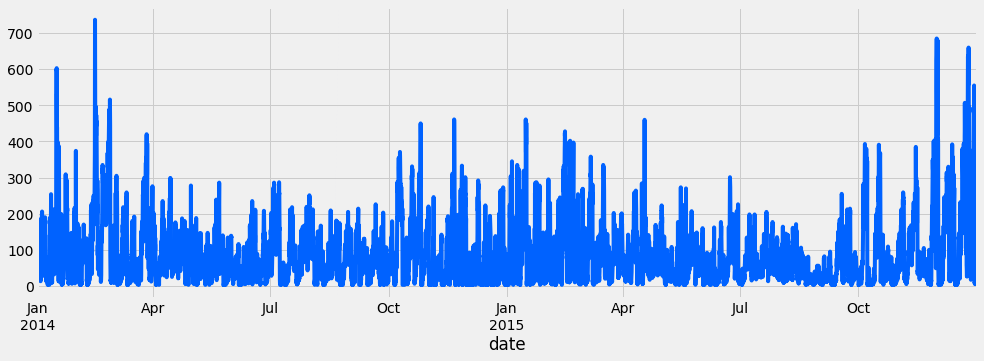

In [82]:
#quick plot of full time series
plt.figure(figsize = (15,5))
df_Beijing['PM_Dongsi'].plot()

In [14]:
df_Beijing['PM_Dongsi'].max()

685.0

In [15]:
df_Beijing['PM_Dongsi']

date
2015-01-01 00:00:00      5.0
2015-01-01 01:00:00      4.0
2015-01-01 02:00:00      3.0
2015-01-01 03:00:00      4.0
2015-01-01 04:00:00      3.0
                       ...  
2015-12-31 19:00:00    140.0
2015-12-31 20:00:00    157.0
2015-12-31 21:00:00    171.0
2015-12-31 22:00:00    204.0
2015-12-31 23:00:00    204.0
Name: PM_Dongsi, Length: 8760, dtype: float64

As usual, it's a good idea for us to generate a run-sequence plot before modeling the data. This way we can get a feel for what we're working with. We'll go ahead and define two utility functions that let us extract and plot the last $n$ days of data (remember that this is an hourly time series, so each day has 24 time steps).   

In [16]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

What do the last 6 weeks of data look like?

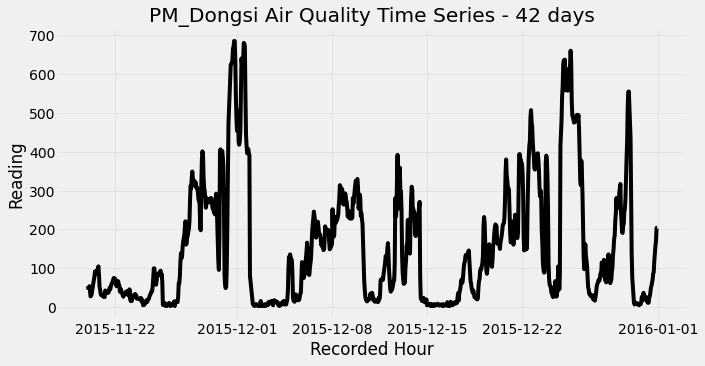

In [17]:
plot_n_last_days(df_Beijing, 'PM_Dongsi', 42)

In [18]:
type(get_n_last_days(df_Beijing, 'PM_Dongsi', 42).values)

numpy.ndarray

**Review Question**: what components that you've learned in previous lessons appear to be present in this time series? 

**Answer**: There appears to be a periodic component as well as autocorrelation structure.

#### Example 1: Train a simple RNN to forecast the PM_Dongsi time series

Before we can train a neural network with keras, we need to process the data into a format that the library accepts. In particular, for keras RNNs and LSTMs, training samples should be stored in a 3D numpy array of shape **(n_samples, time_steps, n_features)**. Since we'll be using only the series' history to predict its future, we'll only have 1 feature. Also, for the next-step prediction that we'll do in this notebook, target values can be stored in a simple list.

To this end, we define utility functions that allow us to extract the formatted data. The **get_train_test_data** function gives us the flexibility to define the length of the extracted training and test sequences and the number of time steps to use for prediction -- we'll run simple tests of our models by holding out the end of the extracted sequence and generating predictions to compare against the ground truth.

Since our model will perform better with multiple training samples, we draw many slices from the entire training sequence, starting at different points in time. The gap between starting points of these slices is controlled by the **sample_gap** parameter.

In [19]:
df_Beijing.shape

(8760, 19)

In [20]:
df_Beijing['PM_Dongsi'].values[-24:]

array([ 21.,  25.,  25.,  27.,  21.,  15.,  15.,  11.,  12.,  25.,  28.,
        37.,  50.,  55.,  63.,  71.,  86.,  90., 119., 140., 157., 171.,
       204., 204.])

In [21]:
df_Beijing['PM_Dongsi'].values[-24:].shape

(24,)

In [22]:
for i in range(0, 12, 5):
    print(i)

0
5
10


In [23]:
get_n_last_days(df_Beijing, 'PM_Dongsi', 56)

date
2015-11-06 00:00:00     20.0
2015-11-06 01:00:00     15.0
2015-11-06 02:00:00     19.0
2015-11-06 03:00:00     20.0
2015-11-06 04:00:00     20.0
                       ...  
2015-12-31 19:00:00    140.0
2015-12-31 20:00:00    157.0
2015-12-31 21:00:00    171.0
2015-12-31 22:00:00    204.0
2015-12-31 23:00:00    204.0
Name: PM_Dongsi, Length: 1344, dtype: float64

In [24]:
get_n_last_days(df_Beijing, 'PM_Dongsi', 56).values[-24:]

array([ 21.,  25.,  25.,  27.,  21.,  15.,  15.,  11.,  12.,  25.,  28.,
        37.,  50.,  55.,  63.,  71.,  86.,  90., 119., 140., 157., 171.,
       204., 204.])

In [25]:
b = []
b.append(get_n_last_days(df_Beijing, 'PM_Dongsi', 56).values[-24:])
b

[array([ 21.,  25.,  25.,  27.,  21.,  15.,  15.,  11.,  12.,  25.,  28.,
         37.,  50.,  55.,  63.,  71.,  86.,  90., 119., 140., 157., 171.,
        204., 204.])]

In [26]:
bb = np.array(b)
bb

array([[ 21.,  25.,  25.,  27.,  21.,  15.,  15.,  11.,  12.,  25.,  28.,
         37.,  50.,  55.,  63.,  71.,  86.,  90., 119., 140., 157., 171.,
        204., 204.]])

In [27]:
np.array([np.array([1,2,3]), np.array([4,5,6])])

array([[1, 2, 3],
       [4, 5, 6]])

In [28]:
bb.shape[0]

1

In [29]:
bb.shape[1]

24

In [30]:
bb.reshape(1,24,1)

array([[[ 21.],
        [ 25.],
        [ 25.],
        [ 27.],
        [ 21.],
        [ 15.],
        [ 15.],
        [ 11.],
        [ 12.],
        [ 25.],
        [ 28.],
        [ 37.],
        [ 50.],
        [ 55.],
        [ 63.],
        [ 71.],
        [ 86.],
        [ 90.],
        [119.],
        [140.],
        [157.],
        [171.],
        [204.],
        [204.]]])

In [31]:
bb.reshape(1,6,4)

array([[[ 21.,  25.,  25.,  27.],
        [ 21.,  15.,  15.,  11.],
        [ 12.,  25.,  28.,  37.],
        [ 50.,  55.,  63.,  71.],
        [ 86.,  90., 119., 140.],
        [157., 171., 204., 204.]]])

In [32]:
np.array([get_n_last_days(df_Beijing, 'PM_Dongsi', 56).values[-24:][1:4]])

array([[25., 25., 27.]])

In [33]:
get_n_last_days(df_Beijing, 'PM_Dongsi', 56).values[-24:][1]

25.0

In [34]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)  # series.reshape(#n/12, 12, 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
#     series_name = 'PM_Dongsi'
#     series_days = 56
#     input_hours = 12
#     test_hours = 24

    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days
    # ex. array([ 20.,  15.,  19., ..., 171., 204., 204.])
        
    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours
    # ex. array([ 21.,  25.,  25.,  27.,  21.,  15.,  15.,  11.,  12.,  25.,  28.,
    #         37.,  50.,  55.,  63.,  71.,  86.,  90., 119., 140., 157., 171.,
    #         204., 204.])
    
    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

With the **get_train_test_data** utility function in hand, we're all set to extract keras-friendly arrays and start training simple RNN models. We run this function in the cell below. We use the last 56 days of the PM_Dongsi series, and will train a model that takes in 12 time steps in order to predict the next time step. We use the last day of data for visually testing the model.    

In [35]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))

In [36]:
train_y.shape

(436,)

In [37]:
train_X[-2:]

array([[[12.],
        [ 7.],
        [12.],
        [11.],
        [10.],
        [11.],
        [10.],
        [ 8.],
        [ 6.],
        [ 5.],
        [ 7.],
        [ 9.]],

       [[11.],
        [10.],
        [11.],
        [10.],
        [ 8.],
        [ 6.],
        [ 5.],
        [ 7.],
        [ 9.],
        [ 8.],
        [14.],
        [27.]]])

In [38]:
train_y[-2:]

array([ 8., 20.])

In [39]:
test_X_init

array([21., 25., 25., 27., 21., 15., 15., 11., 12., 25., 28., 37.])

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each. 

In [40]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (436, 12, 1)
Training output shape: (436,)
Test input shape: (12,)
Test output shape: (12,)


And now we're ready to train! Since we'd like to repeatedly adjust our model's hyperparameters to see what works best, we'll write a reusable function for training a simple RNN model using keras. Take some time to understand what the keras syntax accomplishes at each step and how it relates to what we've learned about RNNs so far.  

In [41]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

Great, now let's use this function to fit a very simple baseline model.

In [42]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 43259.4648
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 43130.9805
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 42917.6055
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 42871.3047
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 42844.7695
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 42821.2031
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 42798.1250
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 42773.7695
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 42751.4414
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 42728.0508


In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Not bad so far. But we need to work a bit harder to actually extract multi-step predictions from this model, as it was trained to predict only one future time step. For multi-step forecasting, we'll iteratively generate one prediction, append it to the end of the input sequence (and shift that sequence forward by one step), then feed the new sequence back to the model. We stop once we've generated all the time step predictions we need. 

This prediction method and a utility function for plotting its output against the ground truth are defined below. Take some time time to familiarize yourself with the prediction method.    

In [45]:
c = np.array([1,2,3,4,5])
c.copy().reshape(1,-1,1)

array([[[1],
        [2],
        [3],
        [4],
        [5]]])

In [52]:
d = c.copy().reshape(1,-1,1)[:,:,:]

In [58]:
d.reshape(1,-1)

array([[1, 2, 3, 4, 5]])

In [44]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

Ok, we've finally arrived at the time to see how our baseline model does. We can simply run the **predict_and_plot** function on the extracted test data as below, and inspect the resulting plot. 

In [59]:
test_X_init

array([21., 25., 25., 27., 21., 15., 15., 11., 12., 25., 28., 37.])

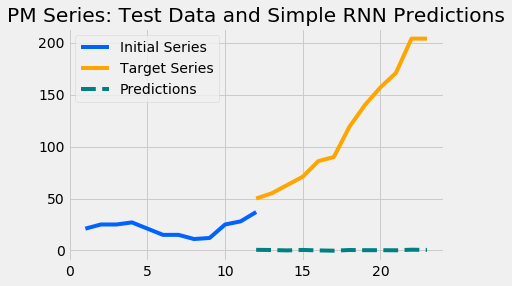

In [18]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

It looks like our model is badly underfit and essentially just making constant predictions. That's ok, it was a very simple baseline and trained very quickly. 

We can improve by making the model more expressive, **increasing cell_units**. We can also pass over the training data many more times, **increasing epochs**, giving the model more opportunity to learn the patterns in the data. We'll try that below, it takes a longer time now since our training is more extensive.

Note that there is a significant amount of randomness in neural network training - we may need to retrain the model a few times in order to get
results that we're happy with.

Epoch 1/1200
7/7 [==============================] - 1s 2ms/step - loss: 43308.8086
Epoch 2/1200
7/7 [==============================] - 0s 2ms/step - loss: 43199.3320
Epoch 3/1200
7/7 [==============================] - 0s 2ms/step - loss: 43023.7695
Epoch 4/1200
7/7 [==============================] - 0s 2ms/step - loss: 42845.2891
Epoch 5/1200
7/7 [==============================] - 0s 2ms/step - loss: 42652.5195
Epoch 6/1200
7/7 [==============================] - 0s 2ms/step - loss: 42469.5625
Epoch 7/1200
7/7 [==============================] - 0s 2ms/step - loss: 42255.1797
Epoch 8/1200
7/7 [==============================] - 0s 2ms/step - loss: 42149.9141
Epoch 9/1200
7/7 [==============================] - 0s 2ms/step - loss: 41974.3477
Epoch 10/1200
7/7 [==============================] - 0s 2ms/step - loss: 41789.5977
Epoch 11/1200
7/7 [==============================] - 0s 3ms/step - loss: 41570.5234
Epoch 12/1200
7/7 [==============================] - 0s 3ms/step - loss: 41431.0586
E

7/7 [==============================] - 0s 2ms/step - loss: 36448.8086
Epoch 99/1200
7/7 [==============================] - 0s 2ms/step - loss: 36397.2578
Epoch 100/1200
7/7 [==============================] - 0s 2ms/step - loss: 36345.4922
Epoch 101/1200
7/7 [==============================] - 0s 2ms/step - loss: 36293.8867
Epoch 102/1200
7/7 [==============================] - 0s 2ms/step - loss: 36244.2734
Epoch 103/1200
7/7 [==============================] - 0s 2ms/step - loss: 36194.2695
Epoch 104/1200
7/7 [==============================] - 0s 2ms/step - loss: 36141.6523
Epoch 105/1200
7/7 [==============================] - 0s 2ms/step - loss: 36090.6055
Epoch 106/1200
7/7 [==============================] - 0s 2ms/step - loss: 36039.4023
Epoch 107/1200
7/7 [==============================] - 0s 2ms/step - loss: 35990.0781
Epoch 108/1200
7/7 [==============================] - 0s 2ms/step - loss: 35939.3320
Epoch 109/1200
7/7 [==============================] - 0s 2ms/step - loss: 35889.1

7/7 [==============================] - 0s 2ms/step - loss: 31911.9688
Epoch 195/1200
7/7 [==============================] - 0s 2ms/step - loss: 31867.0352
Epoch 196/1200
7/7 [==============================] - 0s 2ms/step - loss: 31823.0312
Epoch 197/1200
7/7 [==============================] - 0s 2ms/step - loss: 31780.3809
Epoch 198/1200
7/7 [==============================] - 0s 2ms/step - loss: 31737.3789
Epoch 199/1200
7/7 [==============================] - 0s 2ms/step - loss: 31694.1328
Epoch 200/1200
7/7 [==============================] - 0s 2ms/step - loss: 31649.2148
Epoch 201/1200
7/7 [==============================] - 0s 2ms/step - loss: 31606.9629
Epoch 202/1200
7/7 [==============================] - 0s 2ms/step - loss: 31564.7480
Epoch 203/1200
7/7 [==============================] - 0s 2ms/step - loss: 31520.9082
Epoch 204/1200
7/7 [==============================] - 0s 2ms/step - loss: 31478.7207
Epoch 205/1200
7/7 [==============================] - 0s 2ms/step - loss: 31435.

7/7 [==============================] - 0s 2ms/step - loss: 28032.9590
Epoch 291/1200
7/7 [==============================] - 0s 2ms/step - loss: 27996.4551
Epoch 292/1200
7/7 [==============================] - 0s 2ms/step - loss: 27958.6621
Epoch 293/1200
7/7 [==============================] - 0s 2ms/step - loss: 27921.2480
Epoch 294/1200
7/7 [==============================] - 0s 2ms/step - loss: 27885.9043
Epoch 295/1200
7/7 [==============================] - 0s 2ms/step - loss: 27849.8438
Epoch 296/1200
7/7 [==============================] - 0s 2ms/step - loss: 27814.9492
Epoch 297/1200
7/7 [==============================] - 0s 2ms/step - loss: 27776.5918
Epoch 298/1200
7/7 [==============================] - 0s 2ms/step - loss: 27738.5625
Epoch 299/1200
7/7 [==============================] - 0s 2ms/step - loss: 27700.5078
Epoch 300/1200
7/7 [==============================] - 0s 2ms/step - loss: 27664.2578
Epoch 301/1200
7/7 [==============================] - 0s 2ms/step - loss: 27626.

7/7 [==============================] - 0s 2ms/step - loss: 24681.4258
Epoch 387/1200
7/7 [==============================] - 0s 2ms/step - loss: 24650.0410
Epoch 388/1200
7/7 [==============================] - 0s 2ms/step - loss: 24616.9746
Epoch 389/1200
7/7 [==============================] - 0s 2ms/step - loss: 24584.4883
Epoch 390/1200
7/7 [==============================] - 0s 2ms/step - loss: 24551.8535
Epoch 391/1200
7/7 [==============================] - 0s 2ms/step - loss: 24519.9902
Epoch 392/1200
7/7 [==============================] - 0s 2ms/step - loss: 24486.6270
Epoch 393/1200
7/7 [==============================] - 0s 2ms/step - loss: 24455.5664
Epoch 394/1200
7/7 [==============================] - 0s 2ms/step - loss: 24424.6816
Epoch 395/1200
7/7 [==============================] - 0s 2ms/step - loss: 24390.8340
Epoch 396/1200
7/7 [==============================] - 0s 2ms/step - loss: 24359.7344
Epoch 397/1200
7/7 [==============================] - 0s 2ms/step - loss: 24326.

7/7 [==============================] - 0s 2ms/step - loss: 21739.2070
Epoch 483/1200
7/7 [==============================] - 0s 2ms/step - loss: 21711.3203
Epoch 484/1200
7/7 [==============================] - 0s 2ms/step - loss: 21682.4453
Epoch 485/1200
7/7 [==============================] - 0s 2ms/step - loss: 21652.4688
Epoch 486/1200
7/7 [==============================] - 0s 2ms/step - loss: 21623.0566
Epoch 487/1200
7/7 [==============================] - 0s 2ms/step - loss: 21596.0117
Epoch 488/1200
7/7 [==============================] - 0s 2ms/step - loss: 21565.8027
Epoch 489/1200
7/7 [==============================] - 0s 2ms/step - loss: 21537.1172
Epoch 490/1200
7/7 [==============================] - 0s 2ms/step - loss: 21508.3047
Epoch 491/1200
7/7 [==============================] - 0s 2ms/step - loss: 21480.2676
Epoch 492/1200
7/7 [==============================] - 0s 2ms/step - loss: 21451.1875
Epoch 493/1200
7/7 [==============================] - 0s 2ms/step - loss: 21423.

7/7 [==============================] - 0s 2ms/step - loss: 19131.0684
Epoch 579/1200
7/7 [==============================] - 0s 2ms/step - loss: 19105.3789
Epoch 580/1200
7/7 [==============================] - 0s 2ms/step - loss: 19081.4043
Epoch 581/1200
7/7 [==============================] - 0s 2ms/step - loss: 19055.0215
Epoch 582/1200
7/7 [==============================] - 0s 2ms/step - loss: 19029.5898
Epoch 583/1200
7/7 [==============================] - 0s 2ms/step - loss: 19003.6777
Epoch 584/1200
7/7 [==============================] - 0s 2ms/step - loss: 18977.7539
Epoch 585/1200
7/7 [==============================] - 0s 2ms/step - loss: 18952.8555
Epoch 586/1200
7/7 [==============================] - 0s 2ms/step - loss: 18926.4492
Epoch 587/1200
7/7 [==============================] - 0s 2ms/step - loss: 18900.6074
Epoch 588/1200
7/7 [==============================] - 0s 2ms/step - loss: 18876.9492
Epoch 589/1200
7/7 [==============================] - 0s 2ms/step - loss: 18850.

7/7 [==============================] - 0s 2ms/step - loss: 16816.1602
Epoch 675/1200
7/7 [==============================] - 0s 2ms/step - loss: 16794.1309
Epoch 676/1200
7/7 [==============================] - 0s 2ms/step - loss: 16771.7676
Epoch 677/1200
7/7 [==============================] - 0s 2ms/step - loss: 16749.6406
Epoch 678/1200
7/7 [==============================] - 0s 2ms/step - loss: 16727.0781
Epoch 679/1200
7/7 [==============================] - 0s 2ms/step - loss: 16706.0449
Epoch 680/1200
7/7 [==============================] - 0s 2ms/step - loss: 16692.3613
Epoch 681/1200
7/7 [==============================] - 0s 2ms/step - loss: 16665.9629
Epoch 682/1200
7/7 [==============================] - 0s 2ms/step - loss: 16640.5215
Epoch 683/1200
7/7 [==============================] - 0s 2ms/step - loss: 16619.6289
Epoch 684/1200
7/7 [==============================] - 0s 2ms/step - loss: 16594.4648
Epoch 685/1200
7/7 [==============================] - 0s 2ms/step - loss: 16571.

7/7 [==============================] - 0s 2ms/step - loss: 14777.5908
Epoch 771/1200
7/7 [==============================] - 0s 2ms/step - loss: 14757.1367
Epoch 772/1200
7/7 [==============================] - 0s 2ms/step - loss: 14737.2607
Epoch 773/1200
7/7 [==============================] - 0s 2ms/step - loss: 14717.6572
Epoch 774/1200
7/7 [==============================] - 0s 2ms/step - loss: 14698.2871
Epoch 775/1200
7/7 [==============================] - 0s 2ms/step - loss: 14676.6035
Epoch 776/1200
7/7 [==============================] - 0s 2ms/step - loss: 14662.4316
Epoch 777/1200
7/7 [==============================] - 0s 2ms/step - loss: 14638.7314
Epoch 778/1200
7/7 [==============================] - 0s 2ms/step - loss: 14619.9746
Epoch 779/1200
7/7 [==============================] - 0s 2ms/step - loss: 14608.0303
Epoch 780/1200
7/7 [==============================] - 0s 2ms/step - loss: 14596.1396
Epoch 781/1200
7/7 [==============================] - 0s 2ms/step - loss: 14568.

7/7 [==============================] - 0s 2ms/step - loss: 12977.3271
Epoch 867/1200
7/7 [==============================] - 0s 2ms/step - loss: 12961.7373
Epoch 868/1200
7/7 [==============================] - 0s 2ms/step - loss: 12944.6201
Epoch 869/1200
7/7 [==============================] - 0s 2ms/step - loss: 12921.0762
Epoch 870/1200
7/7 [==============================] - 0s 2ms/step - loss: 12904.5742
Epoch 871/1200
7/7 [==============================] - 0s 2ms/step - loss: 12890.9160
Epoch 872/1200
7/7 [==============================] - 0s 2ms/step - loss: 12871.9414
Epoch 873/1200
7/7 [==============================] - 0s 2ms/step - loss: 12850.6475
Epoch 874/1200
7/7 [==============================] - 0s 2ms/step - loss: 12835.8936
Epoch 875/1200
7/7 [==============================] - 0s 2ms/step - loss: 12816.3008
Epoch 876/1200
7/7 [==============================] - 0s 2ms/step - loss: 12801.3135
Epoch 877/1200
7/7 [==============================] - 0s 2ms/step - loss: 12782.

7/7 [==============================] - 0s 2ms/step - loss: 11401.0420
Epoch 963/1200
7/7 [==============================] - 0s 2ms/step - loss: 11390.1260
Epoch 964/1200
7/7 [==============================] - 0s 2ms/step - loss: 11368.4727
Epoch 965/1200
7/7 [==============================] - 0s 2ms/step - loss: 11357.5049
Epoch 966/1200
7/7 [==============================] - 0s 2ms/step - loss: 11341.0684
Epoch 967/1200
7/7 [==============================] - 0s 2ms/step - loss: 11326.7646
Epoch 968/1200
7/7 [==============================] - 0s 2ms/step - loss: 11309.2314
Epoch 969/1200
7/7 [==============================] - 0s 2ms/step - loss: 11294.0254
Epoch 970/1200
7/7 [==============================] - 0s 2ms/step - loss: 11277.6387
Epoch 971/1200
7/7 [==============================] - 0s 2ms/step - loss: 11266.4131
Epoch 972/1200
7/7 [==============================] - 0s 2ms/step - loss: 11250.0391
Epoch 973/1200
7/7 [==============================] - 0s 2ms/step - loss: 11230.

7/7 [==============================] - 0s 2ms/step - loss: 10047.4541
Epoch 1058/1200
7/7 [==============================] - 0s 2ms/step - loss: 10032.9336
Epoch 1059/1200
7/7 [==============================] - 0s 2ms/step - loss: 10015.8115
Epoch 1060/1200
7/7 [==============================] - 0s 2ms/step - loss: 10002.0908
Epoch 1061/1200
7/7 [==============================] - 0s 2ms/step - loss: 9990.7158
Epoch 1062/1200
7/7 [==============================] - 0s 2ms/step - loss: 9980.5996
Epoch 1063/1200
7/7 [==============================] - 0s 2ms/step - loss: 9966.4961
Epoch 1064/1200
7/7 [==============================] - 0s 2ms/step - loss: 9953.8750
Epoch 1065/1200
7/7 [==============================] - 0s 2ms/step - loss: 9960.8330
Epoch 1066/1200
7/7 [==============================] - 0s 2ms/step - loss: 9946.2217
Epoch 1067/1200
7/7 [==============================] - 0s 2ms/step - loss: 9927.3965
Epoch 1068/1200
7/7 [==============================] - 0s 2ms/step - loss: 99

7/7 [==============================] - 0s 2ms/step - loss: 8850.7012
Epoch 1154/1200
7/7 [==============================] - 0s 2ms/step - loss: 8838.5850
Epoch 1155/1200
7/7 [==============================] - 0s 2ms/step - loss: 8823.6816
Epoch 1156/1200
7/7 [==============================] - 0s 2ms/step - loss: 8813.7354
Epoch 1157/1200
7/7 [==============================] - 0s 2ms/step - loss: 8804.8711
Epoch 1158/1200
7/7 [==============================] - 0s 2ms/step - loss: 8794.0605
Epoch 1159/1200
7/7 [==============================] - 0s 2ms/step - loss: 8782.7676
Epoch 1160/1200
7/7 [==============================] - 0s 2ms/step - loss: 8770.6895
Epoch 1161/1200
7/7 [==============================] - 0s 2ms/step - loss: 8764.1914
Epoch 1162/1200
7/7 [==============================] - 0s 2ms/step - loss: 8750.9922
Epoch 1163/1200
7/7 [==============================] - 0s 2ms/step - loss: 8741.8936
Epoch 1164/1200
7/7 [==============================] - 0s 2ms/step - loss: 8732.3

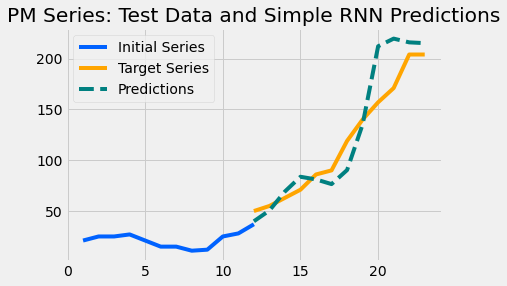

In [60]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

We can definitely get better results than before. Note that the model has the capacity to forecast an upward trend based on the trough pattern that occured recently (the input sequence). 

Once we've created a model object, we can also get information about its structure and number of parameters by using the **summary** function. This is a useful way to measure the complexity of the model and get a feel for how long it may take to train. 

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 30)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


Note that even for this relatively simple model, we already have almost a thousand parameters to train. A larger number of cell units would increase the number of parameters - this is why the training process can become so time consuming.    

#### Exercise 1: Train a simple RNN to forecast the PM_Nongzhanguan time series

We can reuse all of the functions we've defined so far in order to train models on different time series. In this exercise, you'll train your own model to forecast the "PM_Nongzhanguan" series from the Beijing dataframe.

**Step 1**: Interpolate the missing values in the "PM_Nongzhanguan" series and plot the last 42 days of the series to get a feel for the data. 
* We'll do this step together to get started

In [62]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()
df_Beijing['PM_Nongzhanguan'].head(10)

date
2015-01-01 00:00:00     8.0
2015-01-01 01:00:00     7.0
2015-01-01 02:00:00     7.0
2015-01-01 03:00:00    11.0
2015-01-01 04:00:00     5.0
2015-01-01 05:00:00     3.0
2015-01-01 06:00:00     6.0
2015-01-01 07:00:00     7.0
2015-01-01 08:00:00     9.0
2015-01-01 09:00:00    11.0
Name: PM_Nongzhanguan, dtype: float64

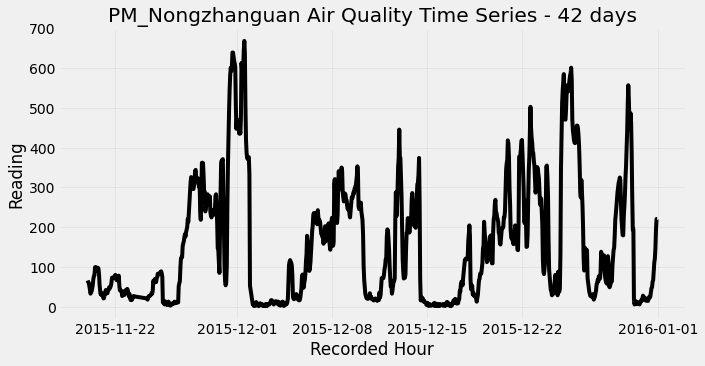

In [65]:
plot_n_last_days(df_Beijing, 'PM_Nongzhanguan', 42)

**Step 2**: Extract the train and test data for the "PM_Nongzhanguan" series using the function **get_train_test_data**. Use the following set of parameters:  

* **series_days** : 56
* **input_hours** : 6
* **test_hours** : 12

For reference, below is how we called the function earlier on. You can also pull up the function's documentation to review the various arguments. 

```
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))
```

In [66]:
series_days = 56
input_hours = 6
test_hours = 12

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

**Step 3**: Using the extracted train data to fit a simple RNN, and use the test data to generate and plot predictions.

* Start with a simple baseline -- few cell units and epochs. From here, try to make the model more expressive by increasing units and epochs until you're satisfied with the model's predictions. 

* Be careful not to set units and/or epochs *too* high. The model may become very slow to train and also start to badly overfit the training data with the extra complexity you've added.

For reference, here's example code that you can adapt:
```
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')
```

Epoch 1/1200
7/7 [==============================] - 1s 2ms/step - loss: 41501.0195
Epoch 2/1200
7/7 [==============================] - 0s 2ms/step - loss: 41436.3477
Epoch 3/1200
7/7 [==============================] - 0s 2ms/step - loss: 41372.5938
Epoch 4/1200
7/7 [==============================] - 0s 2ms/step - loss: 41307.3203
Epoch 5/1200
7/7 [==============================] - 0s 1ms/step - loss: 41239.7539
Epoch 6/1200
7/7 [==============================] - 0s 2ms/step - loss: 41170.9805
Epoch 7/1200
7/7 [==============================] - 0s 2ms/step - loss: 41098.8672
Epoch 8/1200
7/7 [==============================] - 0s 2ms/step - loss: 41013.0508
Epoch 9/1200
7/7 [==============================] - 0s 1ms/step - loss: 40827.9492
Epoch 10/1200
7/7 [==============================] - 0s 2ms/step - loss: 40655.0625
Epoch 11/1200
7/7 [==============================] - 0s 2ms/step - loss: 40400.6367
Epoch 12/1200
7/7 [==============================] - 0s 2ms/step - loss: 40200.7227
E

7/7 [==============================] - 0s 2ms/step - loss: 34823.8047
Epoch 99/1200
7/7 [==============================] - 0s 2ms/step - loss: 34774.0039
Epoch 100/1200
7/7 [==============================] - 0s 2ms/step - loss: 34722.9648
Epoch 101/1200
7/7 [==============================] - 0s 2ms/step - loss: 34672.1484
Epoch 102/1200
7/7 [==============================] - 0s 2ms/step - loss: 34621.4844
Epoch 103/1200
7/7 [==============================] - 0s 1ms/step - loss: 34570.2812
Epoch 104/1200
7/7 [==============================] - 0s 2ms/step - loss: 34519.9219
Epoch 105/1200
7/7 [==============================] - 0s 2ms/step - loss: 34469.6484
Epoch 106/1200
7/7 [==============================] - 0s 1ms/step - loss: 34420.1914
Epoch 107/1200
7/7 [==============================] - 0s 1ms/step - loss: 34368.4766
Epoch 108/1200
7/7 [==============================] - 0s 2ms/step - loss: 34318.4102
Epoch 109/1200
7/7 [==============================] - 0s 1ms/step - loss: 34269.0

7/7 [==============================] - 0s 1ms/step - loss: 30309.5801
Epoch 195/1200
7/7 [==============================] - 0s 2ms/step - loss: 30265.9141
Epoch 196/1200
7/7 [==============================] - 0s 1ms/step - loss: 30223.1582
Epoch 197/1200
7/7 [==============================] - 0s 2ms/step - loss: 30180.9258
Epoch 198/1200
7/7 [==============================] - 0s 2ms/step - loss: 30136.2832
Epoch 199/1200
7/7 [==============================] - 0s 1ms/step - loss: 30094.8672
Epoch 200/1200
7/7 [==============================] - 0s 2ms/step - loss: 30050.7168
Epoch 201/1200
7/7 [==============================] - 0s 2ms/step - loss: 30007.9844
Epoch 202/1200
7/7 [==============================] - 0s 1ms/step - loss: 29965.3145
Epoch 203/1200
7/7 [==============================] - 0s 1ms/step - loss: 29922.6309
Epoch 204/1200
7/7 [==============================] - 0s 2ms/step - loss: 29880.4160
Epoch 205/1200
7/7 [==============================] - 0s 2ms/step - loss: 29836.

7/7 [==============================] - 0s 1ms/step - loss: 26447.1719
Epoch 291/1200
7/7 [==============================] - 0s 1ms/step - loss: 26410.2344
Epoch 292/1200
7/7 [==============================] - 0s 2ms/step - loss: 26373.1094
Epoch 293/1200
7/7 [==============================] - 0s 2ms/step - loss: 26336.2031
Epoch 294/1200
7/7 [==============================] - 0s 2ms/step - loss: 26298.1953
Epoch 295/1200
7/7 [==============================] - 0s 2ms/step - loss: 26260.4160
Epoch 296/1200
7/7 [==============================] - 0s 2ms/step - loss: 26224.7148
Epoch 297/1200
7/7 [==============================] - 0s 2ms/step - loss: 26187.4707
Epoch 298/1200
7/7 [==============================] - 0s 1ms/step - loss: 26149.5156
Epoch 299/1200
7/7 [==============================] - 0s 2ms/step - loss: 26114.7461
Epoch 300/1200
7/7 [==============================] - 0s 2ms/step - loss: 26076.7031
Epoch 301/1200
7/7 [==============================] - 0s 2ms/step - loss: 26039.

7/7 [==============================] - 0s 2ms/step - loss: 23101.7422
Epoch 387/1200
7/7 [==============================] - 0s 2ms/step - loss: 23069.1973
Epoch 388/1200
7/7 [==============================] - 0s 2ms/step - loss: 23037.2246
Epoch 389/1200
7/7 [==============================] - 0s 1ms/step - loss: 23003.9414
Epoch 390/1200
7/7 [==============================] - 0s 1ms/step - loss: 22972.2129
Epoch 391/1200
7/7 [==============================] - 0s 2ms/step - loss: 22939.3418
Epoch 392/1200
7/7 [==============================] - 0s 2ms/step - loss: 22907.4473
Epoch 393/1200
7/7 [==============================] - 0s 2ms/step - loss: 22874.2852
Epoch 394/1200
7/7 [==============================] - 0s 2ms/step - loss: 22842.3730
Epoch 395/1200
7/7 [==============================] - 0s 2ms/step - loss: 22809.5605
Epoch 396/1200
7/7 [==============================] - 0s 2ms/step - loss: 22778.0664
Epoch 397/1200
7/7 [==============================] - 0s 2ms/step - loss: 22745.

7/7 [==============================] - 0s 2ms/step - loss: 20168.8125
Epoch 483/1200
7/7 [==============================] - 0s 2ms/step - loss: 20140.1055
Epoch 484/1200
7/7 [==============================] - 0s 1ms/step - loss: 20111.5293
Epoch 485/1200
7/7 [==============================] - 0s 1ms/step - loss: 20084.3809
Epoch 486/1200
7/7 [==============================] - 0s 1ms/step - loss: 20054.2520
Epoch 487/1200
7/7 [==============================] - 0s 2ms/step - loss: 20026.8418
Epoch 488/1200
7/7 [==============================] - 0s 2ms/step - loss: 19999.0371
Epoch 489/1200
7/7 [==============================] - 0s 2ms/step - loss: 19969.2695
Epoch 490/1200
7/7 [==============================] - 0s 2ms/step - loss: 19940.6523
Epoch 491/1200
7/7 [==============================] - 0s 2ms/step - loss: 19912.1035
Epoch 492/1200
7/7 [==============================] - 0s 2ms/step - loss: 19883.9980
Epoch 493/1200
7/7 [==============================] - 0s 2ms/step - loss: 19855.

7/7 [==============================] - 0s 2ms/step - loss: 17581.0098
Epoch 579/1200
7/7 [==============================] - 0s 2ms/step - loss: 17556.5137
Epoch 580/1200
7/7 [==============================] - 0s 1ms/step - loss: 17529.9590
Epoch 581/1200
7/7 [==============================] - 0s 2ms/step - loss: 17505.2871
Epoch 582/1200
7/7 [==============================] - 0s 1ms/step - loss: 17480.0430
Epoch 583/1200
7/7 [==============================] - 0s 1ms/step - loss: 17456.2988
Epoch 584/1200
7/7 [==============================] - 0s 2ms/step - loss: 17429.7090
Epoch 585/1200
7/7 [==============================] - 0s 2ms/step - loss: 17404.9707
Epoch 586/1200
7/7 [==============================] - 0s 1ms/step - loss: 17379.1230
Epoch 587/1200
7/7 [==============================] - 0s 2ms/step - loss: 17356.0117
Epoch 588/1200
7/7 [==============================] - 0s 1ms/step - loss: 17329.2637
Epoch 589/1200
7/7 [==============================] - 0s 2ms/step - loss: 17303.

7/7 [==============================] - 0s 2ms/step - loss: 15271.7764
Epoch 675/1200
7/7 [==============================] - 0s 2ms/step - loss: 15249.3477
Epoch 676/1200
7/7 [==============================] - 0s 1ms/step - loss: 15225.6191
Epoch 677/1200
7/7 [==============================] - 0s 1ms/step - loss: 15204.0352
Epoch 678/1200
7/7 [==============================] - 0s 2ms/step - loss: 15183.7871
Epoch 679/1200
7/7 [==============================] - 0s 2ms/step - loss: 15158.0977
Epoch 680/1200
7/7 [==============================] - 0s 1ms/step - loss: 15137.8066
Epoch 681/1200
7/7 [==============================] - 0s 1ms/step - loss: 15116.0215
Epoch 682/1200
7/7 [==============================] - 0s 2ms/step - loss: 15094.2285
Epoch 683/1200
7/7 [==============================] - 0s 1ms/step - loss: 15071.1367
Epoch 684/1200
7/7 [==============================] - 0s 1ms/step - loss: 15046.9277
Epoch 685/1200
7/7 [==============================] - 0s 2ms/step - loss: 15027.

7/7 [==============================] - 0s 2ms/step - loss: 13266.9941
Epoch 771/1200
7/7 [==============================] - 0s 1ms/step - loss: 13247.4561
Epoch 772/1200
7/7 [==============================] - 0s 2ms/step - loss: 13228.2373
Epoch 773/1200
7/7 [==============================] - 0s 1ms/step - loss: 13209.8086
Epoch 774/1200
7/7 [==============================] - 0s 1ms/step - loss: 13189.8848
Epoch 775/1200
7/7 [==============================] - 0s 2ms/step - loss: 13170.5928
Epoch 776/1200
7/7 [==============================] - 0s 2ms/step - loss: 13150.3223
Epoch 777/1200
7/7 [==============================] - 0s 1ms/step - loss: 13133.7451
Epoch 778/1200
7/7 [==============================] - 0s 1ms/step - loss: 13112.6709
Epoch 779/1200
7/7 [==============================] - 0s 1ms/step - loss: 13095.4834
Epoch 780/1200
7/7 [==============================] - 0s 1ms/step - loss: 13074.4434
Epoch 781/1200
7/7 [==============================] - 0s 2ms/step - loss: 13056.

7/7 [==============================] - 0s 2ms/step - loss: 11522.0596
Epoch 867/1200
7/7 [==============================] - 0s 1ms/step - loss: 11504.0811
Epoch 868/1200
7/7 [==============================] - 0s 1ms/step - loss: 11489.0117
Epoch 869/1200
7/7 [==============================] - 0s 2ms/step - loss: 11471.2949
Epoch 870/1200
7/7 [==============================] - 0s 2ms/step - loss: 11456.6816
Epoch 871/1200
7/7 [==============================] - 0s 2ms/step - loss: 11440.0410
Epoch 872/1200
7/7 [==============================] - 0s 2ms/step - loss: 11421.7549
Epoch 873/1200
7/7 [==============================] - 0s 1ms/step - loss: 11406.7412
Epoch 874/1200
7/7 [==============================] - 0s 2ms/step - loss: 11387.7080
Epoch 875/1200
7/7 [==============================] - 0s 2ms/step - loss: 11372.0518
Epoch 876/1200
7/7 [==============================] - 0s 1ms/step - loss: 11354.1230
Epoch 877/1200
7/7 [==============================] - 0s 1ms/step - loss: 11336.

7/7 [==============================] - 0s 1ms/step - loss: 10006.7744
Epoch 963/1200
7/7 [==============================] - 0s 1ms/step - loss: 9995.1094
Epoch 964/1200
7/7 [==============================] - 0s 1ms/step - loss: 9977.3066
Epoch 965/1200
7/7 [==============================] - 0s 2ms/step - loss: 9964.4863
Epoch 966/1200
7/7 [==============================] - 0s 2ms/step - loss: 9948.9014
Epoch 967/1200
7/7 [==============================] - 0s 1ms/step - loss: 9934.8975
Epoch 968/1200
7/7 [==============================] - 0s 1ms/step - loss: 9919.8232
Epoch 969/1200
7/7 [==============================] - 0s 1ms/step - loss: 9904.8672
Epoch 970/1200
7/7 [==============================] - 0s 2ms/step - loss: 9891.5498
Epoch 971/1200
7/7 [==============================] - 0s 2ms/step - loss: 9876.8311
Epoch 972/1200
7/7 [==============================] - 0s 1ms/step - loss: 9860.7988
Epoch 973/1200
7/7 [==============================] - 0s 2ms/step - loss: 9845.8438
Epoch 

Epoch 1059/1200
7/7 [==============================] - 0s 1ms/step - loss: 8655.9600
Epoch 1060/1200
7/7 [==============================] - 0s 2ms/step - loss: 8642.3496
Epoch 1061/1200
7/7 [==============================] - 0s 1ms/step - loss: 8630.0781
Epoch 1062/1200
7/7 [==============================] - 0s 2ms/step - loss: 8615.9619
Epoch 1063/1200
7/7 [==============================] - 0s 1ms/step - loss: 8603.5137
Epoch 1064/1200
7/7 [==============================] - 0s 1ms/step - loss: 8590.5186
Epoch 1065/1200
7/7 [==============================] - 0s 2ms/step - loss: 8578.2930
Epoch 1066/1200
7/7 [==============================] - 0s 2ms/step - loss: 8565.3496
Epoch 1067/1200
7/7 [==============================] - 0s 2ms/step - loss: 8555.5732
Epoch 1068/1200
7/7 [==============================] - 0s 2ms/step - loss: 8541.9736
Epoch 1069/1200
7/7 [==============================] - 0s 2ms/step - loss: 8528.5410
Epoch 1070/1200
7/7 [==============================] - 0s 1ms/ste

7/7 [==============================] - 0s 1ms/step - loss: 7507.6069
Epoch 1156/1200
7/7 [==============================] - 0s 2ms/step - loss: 7494.9585
Epoch 1157/1200
7/7 [==============================] - 0s 2ms/step - loss: 7488.5703
Epoch 1158/1200
7/7 [==============================] - 0s 1ms/step - loss: 7473.0645
Epoch 1159/1200
7/7 [==============================] - 0s 2ms/step - loss: 7463.4473
Epoch 1160/1200
7/7 [==============================] - 0s 2ms/step - loss: 7449.9639
Epoch 1161/1200
7/7 [==============================] - 0s 2ms/step - loss: 7440.6416
Epoch 1162/1200
7/7 [==============================] - 0s 1ms/step - loss: 7430.3486
Epoch 1163/1200
7/7 [==============================] - 0s 2ms/step - loss: 7420.1797
Epoch 1164/1200
7/7 [==============================] - 0s 2ms/step - loss: 7405.9717
Epoch 1165/1200
7/7 [==============================] - 0s 1ms/step - loss: 7395.1675
Epoch 1166/1200
7/7 [==============================] - 0s 1ms/step - loss: 7383.1

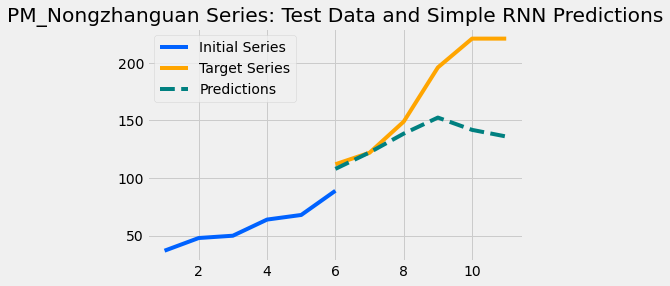

In [67]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and Simple RNN Predictions')

Again, we're able to do a decent job forecasting the continuation of an uptrend. We'll likely face more difficulty if we try to predict further into the future, especially with a simple RNN. 

# Section 2: LSTM

In this section, we'll build on our previous work by introducing LSTM models as an enhancement to the RNNs we've trained so far. Our first step will be to write a new function for fitting an LSTM with keras - notice that it's almost the same as our simple RNN function, with **LSTM** substitued for **SimpleRNN** (this is a nice display of how flexible keras is). 

Take some time to review the logic of the function while we go ahead and run the example cell below (it will take a while). 

In [71]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

#### Example 2: Train a LSTM to forecast the PM_Nongzhanguan time series

With our new LSTM training function and all of our previously defined utility functions, adapting our code for LSTM forecasting will be fairly simple. We can extract the data as we did before, call the **fit_LSTM** function to build a model, and run the same *predict_and_plot* code.

Remember that one of the key benefits of LSTMs over simple RNNs is that they are better equipped to handle long input sequences and long-term dependencies. To see this evidence of this, we'll set *input_hours* to 12 and *test_hours* to 96 and see how our model predictions turn out with LSTM.  

Epoch 1/3000
6/6 [==============================] - 2s 6ms/step - loss: 44351.8281
Epoch 2/3000
6/6 [==============================] - 0s 6ms/step - loss: 44257.9805
Epoch 3/3000
6/6 [==============================] - 0s 6ms/step - loss: 44121.1797
Epoch 4/3000
6/6 [==============================] - 0s 6ms/step - loss: 43889.3633
Epoch 5/3000
6/6 [==============================] - 0s 6ms/step - loss: 43806.6797
Epoch 6/3000
6/6 [==============================] - 0s 6ms/step - loss: 43701.9688
Epoch 7/3000
6/6 [==============================] - 0s 6ms/step - loss: 43575.3477
Epoch 8/3000
6/6 [==============================] - 0s 6ms/step - loss: 43351.0898
Epoch 9/3000
6/6 [==============================] - 0s 6ms/step - loss: 43109.9531
Epoch 10/3000
6/6 [==============================] - 0s 6ms/step - loss: 42853.1641
Epoch 11/3000
6/6 [==============================] - 0s 6ms/step - loss: 42632.8086
Epoch 12/3000
6/6 [==============================] - 0s 6ms/step - loss: 42313.2031
E

6/6 [==============================] - 0s 6ms/step - loss: 32004.5020
Epoch 99/3000
6/6 [==============================] - 0s 6ms/step - loss: 31924.6074
Epoch 100/3000
6/6 [==============================] - 0s 6ms/step - loss: 31844.1504
Epoch 101/3000
6/6 [==============================] - 0s 6ms/step - loss: 31760.4863
Epoch 102/3000
6/6 [==============================] - 0s 6ms/step - loss: 31660.3574
Epoch 103/3000
6/6 [==============================] - 0s 6ms/step - loss: 31564.2168
Epoch 104/3000
6/6 [==============================] - 0s 6ms/step - loss: 31476.7012
Epoch 105/3000
6/6 [==============================] - 0s 6ms/step - loss: 31391.8574
Epoch 106/3000
6/6 [==============================] - 0s 6ms/step - loss: 31306.6504
Epoch 107/3000
6/6 [==============================] - 0s 6ms/step - loss: 31226.3496
Epoch 108/3000
6/6 [==============================] - 0s 5ms/step - loss: 31142.1406
Epoch 109/3000
6/6 [==============================] - 0s 5ms/step - loss: 31059.1

6/6 [==============================] - 0s 6ms/step - loss: 25133.3457
Epoch 195/3000
6/6 [==============================] - 0s 6ms/step - loss: 25072.4785
Epoch 196/3000
6/6 [==============================] - 0s 6ms/step - loss: 25014.5625
Epoch 197/3000
6/6 [==============================] - 0s 6ms/step - loss: 24952.9473
Epoch 198/3000
6/6 [==============================] - 0s 6ms/step - loss: 24893.3984
Epoch 199/3000
6/6 [==============================] - 0s 5ms/step - loss: 24834.4590
Epoch 200/3000
6/6 [==============================] - 0s 6ms/step - loss: 24771.6270
Epoch 201/3000
6/6 [==============================] - 0s 6ms/step - loss: 24712.0254
Epoch 202/3000
6/6 [==============================] - 0s 6ms/step - loss: 24655.0000
Epoch 203/3000
6/6 [==============================] - 0s 6ms/step - loss: 24593.4453
Epoch 204/3000
6/6 [==============================] - 0s 6ms/step - loss: 24533.8359
Epoch 205/3000
6/6 [==============================] - 0s 5ms/step - loss: 24475.

6/6 [==============================] - 0s 6ms/step - loss: 19960.6836
Epoch 291/3000
6/6 [==============================] - 0s 6ms/step - loss: 19913.9492
Epoch 292/3000
6/6 [==============================] - 0s 6ms/step - loss: 19863.6055
Epoch 293/3000
6/6 [==============================] - 0s 6ms/step - loss: 19817.3613
Epoch 294/3000
6/6 [==============================] - 0s 6ms/step - loss: 19770.7441
Epoch 295/3000
6/6 [==============================] - 0s 6ms/step - loss: 19724.4160
Epoch 296/3000
6/6 [==============================] - 0s 6ms/step - loss: 19676.4102
Epoch 297/3000
6/6 [==============================] - 0s 6ms/step - loss: 19629.4727
Epoch 298/3000
6/6 [==============================] - 0s 6ms/step - loss: 19581.4492
Epoch 299/3000
6/6 [==============================] - 0s 6ms/step - loss: 19536.4844
Epoch 300/3000
6/6 [==============================] - 0s 6ms/step - loss: 19489.8438
Epoch 301/3000
6/6 [==============================] - 0s 6ms/step - loss: 19441.

6/6 [==============================] - 0s 6ms/step - loss: 15858.8174
Epoch 387/3000
6/6 [==============================] - 0s 6ms/step - loss: 15819.6963
Epoch 388/3000
6/6 [==============================] - 0s 5ms/step - loss: 15780.8135
Epoch 389/3000
6/6 [==============================] - 0s 6ms/step - loss: 15743.5127
Epoch 390/3000
6/6 [==============================] - 0s 6ms/step - loss: 15704.5137
Epoch 391/3000
6/6 [==============================] - 0s 6ms/step - loss: 15694.7373
Epoch 392/3000
6/6 [==============================] - 0s 6ms/step - loss: 15629.8135
Epoch 393/3000
6/6 [==============================] - 0s 6ms/step - loss: 15593.2002
Epoch 394/3000
6/6 [==============================] - 0s 6ms/step - loss: 15555.1143
Epoch 395/3000
6/6 [==============================] - 0s 6ms/step - loss: 15518.2129
Epoch 396/3000
6/6 [==============================] - 0s 6ms/step - loss: 15479.5195
Epoch 397/3000
6/6 [==============================] - 0s 6ms/step - loss: 15444.

6/6 [==============================] - 0s 6ms/step - loss: 12504.8408
Epoch 483/3000
6/6 [==============================] - 0s 6ms/step - loss: 12474.7842
Epoch 484/3000
6/6 [==============================] - 0s 6ms/step - loss: 12447.2432
Epoch 485/3000
6/6 [==============================] - 0s 6ms/step - loss: 12416.7529
Epoch 486/3000
6/6 [==============================] - 0s 6ms/step - loss: 12387.5166
Epoch 487/3000
6/6 [==============================] - 0s 6ms/step - loss: 12355.9355
Epoch 488/3000
6/6 [==============================] - 0s 6ms/step - loss: 12328.1895
Epoch 489/3000
6/6 [==============================] - 0s 6ms/step - loss: 12296.9990
Epoch 490/3000
6/6 [==============================] - 0s 6ms/step - loss: 12268.1016
Epoch 491/3000
6/6 [==============================] - 0s 5ms/step - loss: 12237.1855
Epoch 492/3000
6/6 [==============================] - 0s 5ms/step - loss: 12206.7100
Epoch 493/3000
6/6 [==============================] - 0s 6ms/step - loss: 12179.

6/6 [==============================] - 0s 6ms/step - loss: 9945.2061
Epoch 579/3000
6/6 [==============================] - 0s 6ms/step - loss: 9923.1475
Epoch 580/3000
6/6 [==============================] - 0s 6ms/step - loss: 9901.2812
Epoch 581/3000
6/6 [==============================] - 0s 6ms/step - loss: 9876.4180
Epoch 582/3000
6/6 [==============================] - 0s 6ms/step - loss: 9856.3164
Epoch 583/3000
6/6 [==============================] - 0s 6ms/step - loss: 9830.6035
Epoch 584/3000
6/6 [==============================] - 0s 6ms/step - loss: 9808.9688
Epoch 585/3000
6/6 [==============================] - 0s 6ms/step - loss: 9785.8164
Epoch 586/3000
6/6 [==============================] - 0s 6ms/step - loss: 9764.2998
Epoch 587/3000
6/6 [==============================] - 0s 6ms/step - loss: 9741.4043
Epoch 588/3000
6/6 [==============================] - 0s 6ms/step - loss: 9718.4766
Epoch 589/3000
6/6 [==============================] - 0s 6ms/step - loss: 9695.7422
Epoch 5

6/6 [==============================] - 0s 6ms/step - loss: 7926.7832
Epoch 676/3000
6/6 [==============================] - 0s 6ms/step - loss: 7906.4023
Epoch 677/3000
6/6 [==============================] - 0s 6ms/step - loss: 7890.3564
Epoch 678/3000
6/6 [==============================] - 0s 6ms/step - loss: 7870.3198
Epoch 679/3000
6/6 [==============================] - 0s 6ms/step - loss: 7851.5439
Epoch 680/3000
6/6 [==============================] - 0s 6ms/step - loss: 7835.7690
Epoch 681/3000
6/6 [==============================] - 0s 6ms/step - loss: 7817.5918
Epoch 682/3000
6/6 [==============================] - 0s 6ms/step - loss: 7801.9072
Epoch 683/3000
6/6 [==============================] - 0s 6ms/step - loss: 7782.2783
Epoch 684/3000
6/6 [==============================] - 0s 6ms/step - loss: 7765.3882
Epoch 685/3000
6/6 [==============================] - 0s 6ms/step - loss: 7747.7925
Epoch 686/3000
6/6 [==============================] - 0s 6ms/step - loss: 7731.3765
Epoch 6

6/6 [==============================] - 0s 6ms/step - loss: 6421.8516
Epoch 773/3000
6/6 [==============================] - 0s 6ms/step - loss: 6412.4614
Epoch 774/3000
6/6 [==============================] - 0s 6ms/step - loss: 6397.1421
Epoch 775/3000
6/6 [==============================] - 0s 6ms/step - loss: 6383.0898
Epoch 776/3000
6/6 [==============================] - 0s 6ms/step - loss: 6375.9126
Epoch 777/3000
6/6 [==============================] - 0s 5ms/step - loss: 6368.1924
Epoch 778/3000
6/6 [==============================] - 0s 5ms/step - loss: 6378.4160
Epoch 779/3000
6/6 [==============================] - 0s 6ms/step - loss: 6352.5674
Epoch 780/3000
6/6 [==============================] - 0s 6ms/step - loss: 6333.8350
Epoch 781/3000
6/6 [==============================] - 0s 6ms/step - loss: 6316.3931
Epoch 782/3000
6/6 [==============================] - 0s 6ms/step - loss: 6306.3818
Epoch 783/3000
6/6 [==============================] - 0s 6ms/step - loss: 6290.4336
Epoch 7

6/6 [==============================] - 0s 6ms/step - loss: 5264.6519
Epoch 870/3000
6/6 [==============================] - 0s 6ms/step - loss: 5254.3906
Epoch 871/3000
6/6 [==============================] - 0s 6ms/step - loss: 5243.4946
Epoch 872/3000
6/6 [==============================] - 0s 6ms/step - loss: 5233.9302
Epoch 873/3000
6/6 [==============================] - 0s 6ms/step - loss: 5225.1377
Epoch 874/3000
6/6 [==============================] - 0s 6ms/step - loss: 5210.3350
Epoch 875/3000
6/6 [==============================] - 0s 6ms/step - loss: 5192.0840
Epoch 876/3000
6/6 [==============================] - 0s 6ms/step - loss: 5180.3394
Epoch 877/3000
6/6 [==============================] - 0s 6ms/step - loss: 5169.3315
Epoch 878/3000
6/6 [==============================] - 0s 5ms/step - loss: 5156.1411
Epoch 879/3000
6/6 [==============================] - 0s 6ms/step - loss: 5148.3970
Epoch 880/3000
6/6 [==============================] - 0s 6ms/step - loss: 5135.0190
Epoch 8

6/6 [==============================] - 0s 6ms/step - loss: 4309.4390
Epoch 967/3000
6/6 [==============================] - 0s 6ms/step - loss: 4301.5078
Epoch 968/3000
6/6 [==============================] - 0s 6ms/step - loss: 4293.8789
Epoch 969/3000
6/6 [==============================] - 0s 6ms/step - loss: 4283.9912
Epoch 970/3000
6/6 [==============================] - 0s 6ms/step - loss: 4271.3984
Epoch 971/3000
6/6 [==============================] - 0s 6ms/step - loss: 4263.8296
Epoch 972/3000
6/6 [==============================] - 0s 6ms/step - loss: 4250.3320
Epoch 973/3000
6/6 [==============================] - 0s 6ms/step - loss: 4242.6270
Epoch 974/3000
6/6 [==============================] - 0s 6ms/step - loss: 4231.6792
Epoch 975/3000
6/6 [==============================] - 0s 6ms/step - loss: 4221.9287
Epoch 976/3000
6/6 [==============================] - 0s 6ms/step - loss: 4212.2715
Epoch 977/3000
6/6 [==============================] - 0s 6ms/step - loss: 4205.2612
Epoch 9

Epoch 1063/3000
6/6 [==============================] - 0s 6ms/step - loss: 3506.8657
Epoch 1064/3000
6/6 [==============================] - 0s 6ms/step - loss: 3499.5161
Epoch 1065/3000
6/6 [==============================] - 0s 6ms/step - loss: 3490.6692
Epoch 1066/3000
6/6 [==============================] - 0s 6ms/step - loss: 3483.9204
Epoch 1067/3000
6/6 [==============================] - 0s 6ms/step - loss: 3475.7102
Epoch 1068/3000
6/6 [==============================] - 0s 6ms/step - loss: 3466.2178
Epoch 1069/3000
6/6 [==============================] - 0s 6ms/step - loss: 3460.7415
Epoch 1070/3000
6/6 [==============================] - 0s 6ms/step - loss: 3451.2278
Epoch 1071/3000
6/6 [==============================] - 0s 6ms/step - loss: 3444.4482
Epoch 1072/3000
6/6 [==============================] - 0s 6ms/step - loss: 3439.3311
Epoch 1073/3000
6/6 [==============================] - 0s 6ms/step - loss: 3430.4424
Epoch 1074/3000
6/6 [==============================] - 0s 6ms/ste

6/6 [==============================] - 0s 6ms/step - loss: 2831.1218
Epoch 1160/3000
6/6 [==============================] - 0s 6ms/step - loss: 2825.1011
Epoch 1161/3000
6/6 [==============================] - 0s 5ms/step - loss: 2818.4888
Epoch 1162/3000
6/6 [==============================] - 0s 6ms/step - loss: 2820.9800
Epoch 1163/3000
6/6 [==============================] - 0s 5ms/step - loss: 2809.9973
Epoch 1164/3000
6/6 [==============================] - 0s 6ms/step - loss: 2796.9990
Epoch 1165/3000
6/6 [==============================] - 0s 6ms/step - loss: 2796.1167
Epoch 1166/3000
6/6 [==============================] - 0s 6ms/step - loss: 2793.0835
Epoch 1167/3000
6/6 [==============================] - 0s 5ms/step - loss: 2788.9434
Epoch 1168/3000
6/6 [==============================] - 0s 5ms/step - loss: 2791.1621
Epoch 1169/3000
6/6 [==============================] - 0s 6ms/step - loss: 2791.9858
Epoch 1170/3000
6/6 [==============================] - 0s 6ms/step - loss: 2783.2

6/6 [==============================] - 0s 6ms/step - loss: 2288.3948
Epoch 1256/3000
6/6 [==============================] - 0s 6ms/step - loss: 2282.4546
Epoch 1257/3000
6/6 [==============================] - 0s 6ms/step - loss: 2281.1118
Epoch 1258/3000
6/6 [==============================] - 0s 6ms/step - loss: 2280.5750
Epoch 1259/3000
6/6 [==============================] - 0s 6ms/step - loss: 2273.9126
Epoch 1260/3000
6/6 [==============================] - 0s 6ms/step - loss: 2276.0630
Epoch 1261/3000
6/6 [==============================] - 0s 6ms/step - loss: 2278.1990
Epoch 1262/3000
6/6 [==============================] - 0s 6ms/step - loss: 2256.2861
Epoch 1263/3000
6/6 [==============================] - 0s 5ms/step - loss: 2250.9678
Epoch 1264/3000
6/6 [==============================] - 0s 6ms/step - loss: 2243.6633
Epoch 1265/3000
6/6 [==============================] - 0s 6ms/step - loss: 2237.6414
Epoch 1266/3000
6/6 [==============================] - 0s 6ms/step - loss: 2246.3

6/6 [==============================] - 0s 5ms/step - loss: 1846.3352
Epoch 1352/3000
6/6 [==============================] - 0s 6ms/step - loss: 1840.8956
Epoch 1353/3000
6/6 [==============================] - 0s 5ms/step - loss: 1839.5193
Epoch 1354/3000
6/6 [==============================] - 0s 6ms/step - loss: 1840.0819
Epoch 1355/3000
6/6 [==============================] - 0s 6ms/step - loss: 1846.2225
Epoch 1356/3000
6/6 [==============================] - 0s 6ms/step - loss: 1840.7242
Epoch 1357/3000
6/6 [==============================] - 0s 6ms/step - loss: 1836.5168
Epoch 1358/3000
6/6 [==============================] - 0s 6ms/step - loss: 1830.6089
Epoch 1359/3000
6/6 [==============================] - 0s 6ms/step - loss: 1825.6115
Epoch 1360/3000
6/6 [==============================] - 0s 5ms/step - loss: 1817.7533
Epoch 1361/3000
6/6 [==============================] - 0s 6ms/step - loss: 1808.2235
Epoch 1362/3000
6/6 [==============================] - 0s 6ms/step - loss: 1804.9

6/6 [==============================] - 0s 6ms/step - loss: 1480.8573
Epoch 1448/3000
6/6 [==============================] - 0s 6ms/step - loss: 1479.5432
Epoch 1449/3000
6/6 [==============================] - 0s 6ms/step - loss: 1492.1952
Epoch 1450/3000
6/6 [==============================] - 0s 6ms/step - loss: 1471.0846
Epoch 1451/3000
6/6 [==============================] - 0s 6ms/step - loss: 1462.8424
Epoch 1452/3000
6/6 [==============================] - 0s 6ms/step - loss: 1457.1448
Epoch 1453/3000
6/6 [==============================] - 0s 6ms/step - loss: 1458.2417
Epoch 1454/3000
6/6 [==============================] - 0s 6ms/step - loss: 1458.1913
Epoch 1455/3000
6/6 [==============================] - 0s 6ms/step - loss: 1449.3036
Epoch 1456/3000
6/6 [==============================] - 0s 6ms/step - loss: 1455.2471
Epoch 1457/3000
6/6 [==============================] - 0s 6ms/step - loss: 1450.2368
Epoch 1458/3000
6/6 [==============================] - 0s 6ms/step - loss: 1459.8

6/6 [==============================] - 0s 6ms/step - loss: 1187.0265
Epoch 1544/3000
6/6 [==============================] - 0s 6ms/step - loss: 1183.5120
Epoch 1545/3000
6/6 [==============================] - 0s 6ms/step - loss: 1179.9493
Epoch 1546/3000
6/6 [==============================] - 0s 5ms/step - loss: 1174.2866
Epoch 1547/3000
6/6 [==============================] - 0s 6ms/step - loss: 1171.9889
Epoch 1548/3000
6/6 [==============================] - 0s 5ms/step - loss: 1169.5238
Epoch 1549/3000
6/6 [==============================] - 0s 6ms/step - loss: 1167.4336
Epoch 1550/3000
6/6 [==============================] - 0s 6ms/step - loss: 1160.5634
Epoch 1551/3000
6/6 [==============================] - 0s 6ms/step - loss: 1163.8494
Epoch 1552/3000
6/6 [==============================] - 0s 6ms/step - loss: 1190.8667
Epoch 1553/3000
6/6 [==============================] - 0s 5ms/step - loss: 1213.6292
Epoch 1554/3000
6/6 [==============================] - 0s 5ms/step - loss: 1193.7

6/6 [==============================] - 0s 6ms/step - loss: 949.7784
Epoch 1640/3000
6/6 [==============================] - 0s 6ms/step - loss: 958.3387
Epoch 1641/3000
6/6 [==============================] - 0s 6ms/step - loss: 936.8689
Epoch 1642/3000
6/6 [==============================] - 0s 6ms/step - loss: 934.7842
Epoch 1643/3000
6/6 [==============================] - 0s 6ms/step - loss: 930.4821
Epoch 1644/3000
6/6 [==============================] - 0s 6ms/step - loss: 935.4468
Epoch 1645/3000
6/6 [==============================] - 0s 5ms/step - loss: 922.5845
Epoch 1646/3000
6/6 [==============================] - 0s 6ms/step - loss: 927.7505
Epoch 1647/3000
6/6 [==============================] - 0s 5ms/step - loss: 920.0101
Epoch 1648/3000
6/6 [==============================] - 0s 6ms/step - loss: 924.5344
Epoch 1649/3000
6/6 [==============================] - 0s 6ms/step - loss: 928.5479
Epoch 1650/3000
6/6 [==============================] - 0s 6ms/step - loss: 932.6978
Epoch 16

6/6 [==============================] - 0s 6ms/step - loss: 720.4562
Epoch 1737/3000
6/6 [==============================] - 0s 5ms/step - loss: 715.5553
Epoch 1738/3000
6/6 [==============================] - 0s 6ms/step - loss: 712.1202
Epoch 1739/3000
6/6 [==============================] - 0s 5ms/step - loss: 719.0701
Epoch 1740/3000
6/6 [==============================] - 0s 6ms/step - loss: 719.0938
Epoch 1741/3000
6/6 [==============================] - 0s 6ms/step - loss: 722.4339
Epoch 1742/3000
6/6 [==============================] - 0s 5ms/step - loss: 711.1235
Epoch 1743/3000
6/6 [==============================] - 0s 6ms/step - loss: 711.5216
Epoch 1744/3000
6/6 [==============================] - 0s 6ms/step - loss: 743.4801
Epoch 1745/3000
6/6 [==============================] - 0s 6ms/step - loss: 746.9111
Epoch 1746/3000
6/6 [==============================] - 0s 6ms/step - loss: 731.1680
Epoch 1747/3000
6/6 [==============================] - 0s 6ms/step - loss: 721.2987
Epoch 17

6/6 [==============================] - 0s 5ms/step - loss: 596.8364
Epoch 1834/3000
6/6 [==============================] - 0s 6ms/step - loss: 603.6942
Epoch 1835/3000
6/6 [==============================] - 0s 6ms/step - loss: 591.5160
Epoch 1836/3000
6/6 [==============================] - 0s 6ms/step - loss: 587.1594
Epoch 1837/3000
6/6 [==============================] - 0s 6ms/step - loss: 574.3640
Epoch 1838/3000
6/6 [==============================] - 0s 5ms/step - loss: 611.1731
Epoch 1839/3000
6/6 [==============================] - 0s 6ms/step - loss: 576.9620
Epoch 1840/3000
6/6 [==============================] - 0s 6ms/step - loss: 586.6649
Epoch 1841/3000
6/6 [==============================] - 0s 6ms/step - loss: 580.7714
Epoch 1842/3000
6/6 [==============================] - 0s 5ms/step - loss: 554.4786
Epoch 1843/3000
6/6 [==============================] - 0s 5ms/step - loss: 551.0847
Epoch 1844/3000
6/6 [==============================] - 0s 6ms/step - loss: 540.4645
Epoch 18

6/6 [==============================] - 0s 6ms/step - loss: 400.4438
Epoch 1931/3000
6/6 [==============================] - 0s 6ms/step - loss: 400.6869
Epoch 1932/3000
6/6 [==============================] - 0s 5ms/step - loss: 401.2977
Epoch 1933/3000
6/6 [==============================] - 0s 5ms/step - loss: 397.7547
Epoch 1934/3000
6/6 [==============================] - 0s 6ms/step - loss: 389.5682
Epoch 1935/3000
6/6 [==============================] - 0s 5ms/step - loss: 389.7316
Epoch 1936/3000
6/6 [==============================] - 0s 6ms/step - loss: 387.2080
Epoch 1937/3000
6/6 [==============================] - 0s 5ms/step - loss: 388.6715
Epoch 1938/3000
6/6 [==============================] - 0s 6ms/step - loss: 387.2776
Epoch 1939/3000
6/6 [==============================] - 0s 5ms/step - loss: 388.6748
Epoch 1940/3000
6/6 [==============================] - 0s 6ms/step - loss: 389.1362
Epoch 1941/3000
6/6 [==============================] - 0s 5ms/step - loss: 392.6662
Epoch 19

6/6 [==============================] - 0s 6ms/step - loss: 297.6085
Epoch 2028/3000
6/6 [==============================] - 0s 6ms/step - loss: 296.4178
Epoch 2029/3000
6/6 [==============================] - 0s 6ms/step - loss: 288.8499
Epoch 2030/3000
6/6 [==============================] - 0s 6ms/step - loss: 283.4131
Epoch 2031/3000
6/6 [==============================] - 0s 6ms/step - loss: 286.1941
Epoch 2032/3000
6/6 [==============================] - 0s 6ms/step - loss: 285.6857
Epoch 2033/3000
6/6 [==============================] - 0s 6ms/step - loss: 295.0768
Epoch 2034/3000
6/6 [==============================] - 0s 6ms/step - loss: 303.3898
Epoch 2035/3000
6/6 [==============================] - 0s 6ms/step - loss: 293.2237
Epoch 2036/3000
6/6 [==============================] - 0s 6ms/step - loss: 299.4431
Epoch 2037/3000
6/6 [==============================] - 0s 5ms/step - loss: 290.9568
Epoch 2038/3000
6/6 [==============================] - 0s 6ms/step - loss: 280.7274
Epoch 20

6/6 [==============================] - 0s 6ms/step - loss: 211.0787
Epoch 2125/3000
6/6 [==============================] - 0s 5ms/step - loss: 209.7831
Epoch 2126/3000
6/6 [==============================] - 0s 6ms/step - loss: 210.3014
Epoch 2127/3000
6/6 [==============================] - 0s 6ms/step - loss: 208.7679
Epoch 2128/3000
6/6 [==============================] - 0s 6ms/step - loss: 210.2176
Epoch 2129/3000
6/6 [==============================] - 0s 6ms/step - loss: 211.0301
Epoch 2130/3000
6/6 [==============================] - 0s 6ms/step - loss: 216.6131
Epoch 2131/3000
6/6 [==============================] - 0s 6ms/step - loss: 209.0372
Epoch 2132/3000
6/6 [==============================] - 0s 5ms/step - loss: 213.3372
Epoch 2133/3000
6/6 [==============================] - 0s 6ms/step - loss: 219.2453
Epoch 2134/3000
6/6 [==============================] - 0s 5ms/step - loss: 226.2800
Epoch 2135/3000
6/6 [==============================] - 0s 6ms/step - loss: 241.6713
Epoch 21

6/6 [==============================] - 0s 6ms/step - loss: 153.4745
Epoch 2222/3000
6/6 [==============================] - 0s 6ms/step - loss: 154.1448
Epoch 2223/3000
6/6 [==============================] - 0s 5ms/step - loss: 156.4588
Epoch 2224/3000
6/6 [==============================] - 0s 6ms/step - loss: 159.6187
Epoch 2225/3000
6/6 [==============================] - 0s 5ms/step - loss: 163.1247
Epoch 2226/3000
6/6 [==============================] - 0s 6ms/step - loss: 174.8141
Epoch 2227/3000
6/6 [==============================] - 0s 5ms/step - loss: 185.7799
Epoch 2228/3000
6/6 [==============================] - 0s 6ms/step - loss: 180.1885
Epoch 2229/3000
6/6 [==============================] - 0s 6ms/step - loss: 173.4325
Epoch 2230/3000
6/6 [==============================] - 0s 6ms/step - loss: 191.0255
Epoch 2231/3000
6/6 [==============================] - 0s 6ms/step - loss: 172.3366
Epoch 2232/3000
6/6 [==============================] - 0s 6ms/step - loss: 171.7409
Epoch 22

6/6 [==============================] - 0s 6ms/step - loss: 210.7105
Epoch 2319/3000
6/6 [==============================] - 0s 6ms/step - loss: 196.5617
Epoch 2320/3000
6/6 [==============================] - 0s 6ms/step - loss: 237.1931
Epoch 2321/3000
6/6 [==============================] - 0s 6ms/step - loss: 213.1517
Epoch 2322/3000
6/6 [==============================] - 0s 5ms/step - loss: 221.0576
Epoch 2323/3000
6/6 [==============================] - 0s 6ms/step - loss: 164.4229
Epoch 2324/3000
6/6 [==============================] - 0s 5ms/step - loss: 170.2210
Epoch 2325/3000
6/6 [==============================] - 0s 6ms/step - loss: 156.6472
Epoch 2326/3000
6/6 [==============================] - 0s 6ms/step - loss: 154.6899
Epoch 2327/3000
6/6 [==============================] - 0s 6ms/step - loss: 146.9807
Epoch 2328/3000
6/6 [==============================] - 0s 6ms/step - loss: 148.8127
Epoch 2329/3000
6/6 [==============================] - 0s 6ms/step - loss: 137.4432
Epoch 23

6/6 [==============================] - 0s 6ms/step - loss: 103.1359
Epoch 2416/3000
6/6 [==============================] - 0s 6ms/step - loss: 106.2272
Epoch 2417/3000
6/6 [==============================] - 0s 6ms/step - loss: 111.3942
Epoch 2418/3000
6/6 [==============================] - 0s 5ms/step - loss: 133.5605
Epoch 2419/3000
6/6 [==============================] - 0s 5ms/step - loss: 112.2679
Epoch 2420/3000
6/6 [==============================] - 0s 6ms/step - loss: 109.7210
Epoch 2421/3000
6/6 [==============================] - 0s 6ms/step - loss: 110.0432
Epoch 2422/3000
6/6 [==============================] - 0s 5ms/step - loss: 108.0036
Epoch 2423/3000
6/6 [==============================] - 0s 6ms/step - loss: 109.4417
Epoch 2424/3000
6/6 [==============================] - 0s 6ms/step - loss: 107.6029
Epoch 2425/3000
6/6 [==============================] - 0s 6ms/step - loss: 102.0237
Epoch 2426/3000
6/6 [==============================] - 0s 5ms/step - loss: 99.0680
Epoch 242

6/6 [==============================] - 0s 6ms/step - loss: 94.7416
Epoch 2514/3000
6/6 [==============================] - 0s 5ms/step - loss: 93.4255
Epoch 2515/3000
6/6 [==============================] - 0s 6ms/step - loss: 88.8328
Epoch 2516/3000
6/6 [==============================] - 0s 6ms/step - loss: 86.9943
Epoch 2517/3000
6/6 [==============================] - 0s 6ms/step - loss: 86.3174
Epoch 2518/3000
6/6 [==============================] - 0s 6ms/step - loss: 81.2338
Epoch 2519/3000
6/6 [==============================] - 0s 6ms/step - loss: 80.9183
Epoch 2520/3000
6/6 [==============================] - 0s 6ms/step - loss: 81.4047
Epoch 2521/3000
6/6 [==============================] - 0s 6ms/step - loss: 80.1848
Epoch 2522/3000
6/6 [==============================] - 0s 6ms/step - loss: 78.2379
Epoch 2523/3000
6/6 [==============================] - 0s 6ms/step - loss: 79.1342
Epoch 2524/3000
6/6 [==============================] - 0s 6ms/step - loss: 79.1084
Epoch 2525/3000
6/6 

6/6 [==============================] - 0s 6ms/step - loss: 70.5603
Epoch 2612/3000
6/6 [==============================] - 0s 6ms/step - loss: 68.5164
Epoch 2613/3000
6/6 [==============================] - 0s 6ms/step - loss: 69.7747
Epoch 2614/3000
6/6 [==============================] - 0s 6ms/step - loss: 69.6495
Epoch 2615/3000
6/6 [==============================] - 0s 6ms/step - loss: 69.5645
Epoch 2616/3000
6/6 [==============================] - 0s 6ms/step - loss: 69.5321
Epoch 2617/3000
6/6 [==============================] - 0s 6ms/step - loss: 68.9761
Epoch 2618/3000
6/6 [==============================] - 0s 6ms/step - loss: 69.2537
Epoch 2619/3000
6/6 [==============================] - 0s 6ms/step - loss: 69.4527
Epoch 2620/3000
6/6 [==============================] - 0s 6ms/step - loss: 70.2134
Epoch 2621/3000
6/6 [==============================] - 0s 6ms/step - loss: 71.2892
Epoch 2622/3000
6/6 [==============================] - 0s 6ms/step - loss: 69.9428
Epoch 2623/3000
6/6 

6/6 [==============================] - 0s 6ms/step - loss: 59.6965
Epoch 2710/3000
6/6 [==============================] - 0s 6ms/step - loss: 60.0529
Epoch 2711/3000
6/6 [==============================] - 0s 6ms/step - loss: 61.8252
Epoch 2712/3000
6/6 [==============================] - 0s 6ms/step - loss: 62.4705
Epoch 2713/3000
6/6 [==============================] - 0s 6ms/step - loss: 62.3517
Epoch 2714/3000
6/6 [==============================] - 0s 6ms/step - loss: 63.7721
Epoch 2715/3000
6/6 [==============================] - 0s 6ms/step - loss: 64.1541
Epoch 2716/3000
6/6 [==============================] - 0s 6ms/step - loss: 65.3678
Epoch 2717/3000
6/6 [==============================] - 0s 6ms/step - loss: 70.4341
Epoch 2718/3000
6/6 [==============================] - 0s 6ms/step - loss: 69.9778
Epoch 2719/3000
6/6 [==============================] - 0s 6ms/step - loss: 68.8530
Epoch 2720/3000
6/6 [==============================] - 0s 6ms/step - loss: 66.7358
Epoch 2721/3000
6/6 

6/6 [==============================] - 0s 6ms/step - loss: 65.5829
Epoch 2808/3000
6/6 [==============================] - 0s 6ms/step - loss: 65.3909
Epoch 2809/3000
6/6 [==============================] - 0s 6ms/step - loss: 62.7368
Epoch 2810/3000
6/6 [==============================] - 0s 6ms/step - loss: 62.0452
Epoch 2811/3000
6/6 [==============================] - 0s 6ms/step - loss: 62.6561
Epoch 2812/3000
6/6 [==============================] - 0s 6ms/step - loss: 62.7606
Epoch 2813/3000
6/6 [==============================] - 0s 6ms/step - loss: 62.8583
Epoch 2814/3000
6/6 [==============================] - 0s 6ms/step - loss: 61.4946
Epoch 2815/3000
6/6 [==============================] - 0s 5ms/step - loss: 64.6478
Epoch 2816/3000
6/6 [==============================] - 0s 6ms/step - loss: 63.9657
Epoch 2817/3000
6/6 [==============================] - 0s 6ms/step - loss: 63.6695
Epoch 2818/3000
6/6 [==============================] - 0s 5ms/step - loss: 61.1487
Epoch 2819/3000
6/6 

6/6 [==============================] - 0s 6ms/step - loss: 54.0214
Epoch 2906/3000
6/6 [==============================] - 0s 6ms/step - loss: 53.2557
Epoch 2907/3000
6/6 [==============================] - 0s 5ms/step - loss: 52.4590
Epoch 2908/3000
6/6 [==============================] - 0s 6ms/step - loss: 52.6159
Epoch 2909/3000
6/6 [==============================] - 0s 6ms/step - loss: 52.5435
Epoch 2910/3000
6/6 [==============================] - 0s 6ms/step - loss: 53.1562
Epoch 2911/3000
6/6 [==============================] - 0s 5ms/step - loss: 53.3242
Epoch 2912/3000
6/6 [==============================] - 0s 6ms/step - loss: 53.0158
Epoch 2913/3000
6/6 [==============================] - 0s 5ms/step - loss: 52.7790
Epoch 2914/3000
6/6 [==============================] - 0s 6ms/step - loss: 52.6539
Epoch 2915/3000
6/6 [==============================] - 0s 5ms/step - loss: 52.4264
Epoch 2916/3000
6/6 [==============================] - 0s 6ms/step - loss: 52.1338
Epoch 2917/3000
6/6 

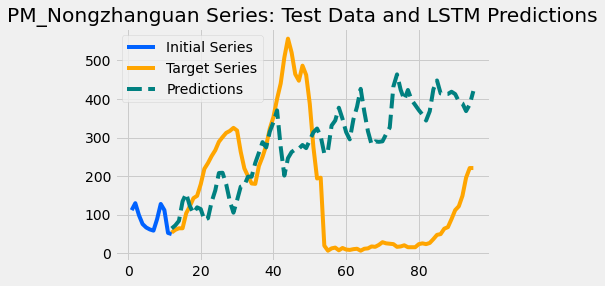

In [72]:
series_days = 50 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000) 

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

Epoch 1/3000
12/12 [==============================] - 2s 6ms/step - loss: nan
Epoch 2/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 3/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 4/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 5/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 6/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 7/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 8/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 9/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 10/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 11/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 12/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 13/3000
12/12 [==============================] - 0s 6ms

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 105/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 106/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 107/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 108/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 109/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 110/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 111/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 112/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 113/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 114/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 115/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 116/3000
12/12 [==============================] -

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 207/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 208/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 209/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 210/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 211/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 212/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 213/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 214/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 215/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 216/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 217/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 218/3000
12/12 [==============================] -

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 309/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 310/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 311/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 312/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 313/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 314/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 315/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 316/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 317/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 318/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 319/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 320/3000
12/12 [==============================] -

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 411/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 412/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 413/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 414/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 415/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 416/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 417/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 418/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 419/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 420/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 421/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 422/3000
12/12 [==============================] -

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 513/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 514/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 515/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 516/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 517/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 518/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 519/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 520/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 521/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 522/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 523/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 524/3000
12/12 [==============================] -

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 615/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 616/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 617/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 618/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 619/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 620/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 621/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 622/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 623/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 624/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 625/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 626/3000
12/12 [==============================] -

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 717/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 718/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 719/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 720/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 721/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 722/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 723/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 724/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 725/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 726/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 727/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 728/3000
12/12 [==============================] -

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 819/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 820/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 821/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 822/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 823/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 824/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 825/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 826/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 827/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 828/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 829/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 830/3000
12/12 [==============================] -

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 921/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 922/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 923/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 924/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 925/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 926/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 927/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 928/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 929/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 930/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 931/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 932/3000
12/12 [==============================] -

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1023/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1024/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1025/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1026/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1027/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1028/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1029/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1030/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1031/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1032/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1033/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1034/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1124/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1125/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1126/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1127/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1128/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1129/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1130/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1131/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1132/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1133/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1134/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1135/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1225/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1226/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1227/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1228/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1229/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1230/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1231/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1232/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1233/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1234/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1235/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1236/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1326/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1327/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1328/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1329/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1330/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1331/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1332/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1333/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1334/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1335/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1336/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1337/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1427/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1428/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1429/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1430/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1431/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1432/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1433/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1434/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1435/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1436/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1437/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1438/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1528/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1529/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1530/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1531/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1532/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1533/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1534/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1535/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1536/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1537/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1538/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1539/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1629/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1630/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1631/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1632/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1633/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1634/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1635/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1636/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1637/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1638/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1639/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1640/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1730/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1731/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1732/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1733/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1734/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1735/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1736/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1737/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1738/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1739/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1740/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1741/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1831/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1832/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1833/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1834/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1835/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1836/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1837/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1838/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1839/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1840/3000
12/12 [==============================] - 0s 7ms/step - loss: nan
Epoch 1841/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1842/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1932/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1933/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1934/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1935/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1936/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1937/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1938/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1939/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1940/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1941/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1942/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 1943/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2033/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2034/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2035/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2036/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2037/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2038/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2039/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2040/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2041/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2042/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2043/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2044/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2134/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2135/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2136/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2137/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2138/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2139/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2140/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2141/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2142/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2143/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2144/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2145/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2235/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2236/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2237/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2238/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2239/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2240/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2241/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2242/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2243/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2244/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2245/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2246/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2336/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2337/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2338/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2339/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2340/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2341/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2342/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2343/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2344/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2345/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2346/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2347/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2437/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2438/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2439/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2440/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2441/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2442/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2443/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2444/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2445/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2446/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2447/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2448/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2538/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2539/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2540/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2541/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2542/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2543/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2544/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2545/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2546/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2547/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2548/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2549/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2639/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2640/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2641/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2642/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2643/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2644/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2645/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2646/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2647/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2648/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2649/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2650/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2740/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2741/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2742/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2743/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2744/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2745/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2746/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2747/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2748/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2749/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2750/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2751/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2841/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2842/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2843/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2844/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2845/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2846/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2847/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2848/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2849/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2850/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2851/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2852/3000
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2942/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2943/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2944/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2945/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2946/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2947/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2948/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2949/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2950/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2951/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2952/3000
12/12 [==============================] - 0s 6ms/step - loss: nan
Epoch 2953/3000
12/12 [=====================

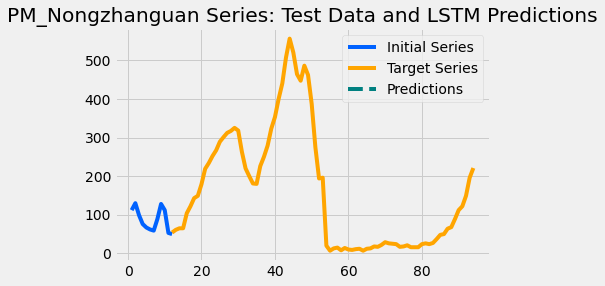

In [84]:
series_days = 100 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000) 

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

In [121]:
series_days = 50 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

In [122]:
train_y.shape

(364,)

In [118]:
series_days = 100 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

In [120]:
train_y.shape

(764,)

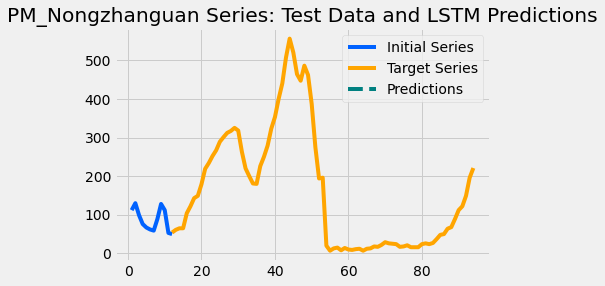

In [112]:
predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

In [87]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 70)                20160     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


In our prediction plot we can start to see how LSTMs can be more expressive than simple RNNs - instead of just extrapolating a simple trend like our previous RNN models did, this LSTM model can effectively anticipate inflection points.

You should also notice that our model starts to struggle toward the end of the predicted sequence, becoming more conservative in its predictions. To improve the quality of forecasts over many time steps, we'd likely need to use more data and more sophisticated LSTM model structures that are beyond the scope of this lesson.

Take a look at the model summary and compare it with the summary for our simple RNN from example 1. You can see that there are many more trainable parameters for the LSTM, which explains why it took a much longer time for us to train this model.

In [73]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                20160     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


#### Further Exploration

The simple models we've worked with are only the tip of the iceberg for deep learning. We've been time-limited for this exercise, and typical deep learning models involve much longer training times than what we're able to do in this notebook. 

Here are several suggestions for how you could explore these ideas further, leveraging the code we've implemented today:

* Try using longer chunks of the series we've looked at in this notebook for modeling (set series_days larger than 56), or modeling other series in the dataset.
* When training with more data, try increasing cell_units and running more training epochs.  
* Try using longer input sequences with LSTM, and predicting a wider range of test hours.

# Summary

In this lesson we have covered:

1. How recurrent neural networks can be applied to sequence forecasting problems
2. How simple RNNs and LSTMs can be built and trained using the python library keras
3. The importance of tuning network parameters, and an introductory strategy for doing so


---
### Machine Learning Foundation (C) 2020 IBM Corporation